In [1]:
import os # 파일 및 디렉터리 관리와 관련된 기능을 제공하는 os 모듈을 불러온다
import glob # 파일 경로를 패턴 매칭하여 검색하기 위한 glob 모듈을 불러온다
import time # 시간과 관련된 기능을 사용하기 위한 time 모듈을 불러온다

import PIL # Python Imaging Library로 이미지 처리와 관련된 기능을 제공
import imageio # 이미지 입출력을 위한 imageio 라이브러리를 불러온다
import numpy as np # 다차원 배열 및 행렬 연산을 위한 NumPy 라이브러리를 불러온다
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display # IPython에서 제공하는 display 모듈을 불러온다. 주로 Jupyter Notebook에서 시각화를 보여줄 때 사용
import matplotlib.pyplot as plt # 데이터 시각화를 위한 Matplotlib 라이브러리의 pyplot 모듈를 불러온다
%matplotlib inline 
# Jupyter Notebook에서 Matplotlib 그래프를 출력할 때 사용되는 매직 명령어로, 그래프를 인라인으로 표시하도록 지정한다

print("tensorflow", tf.__version__) # 현재 사용 중인 TensorFlow 버전을 출력

tensorflow 2.6.0


In [2]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

(50000, 32, 32, 3)

학습에 사용할 train_x의 이미지를 -1, 1로 정규화합니다.\
로드한 학습 데이터를 시각화를 통해 확인해 봅시다.\
tf.data.Dataset 모듈의 from_tensor_slices() 함수를 사용하여 미니배치 데이터셋을 구성해 봅시다.

In [3]:
# train_x를 정규화
train_x = (train_x - 127.5)/127.5

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


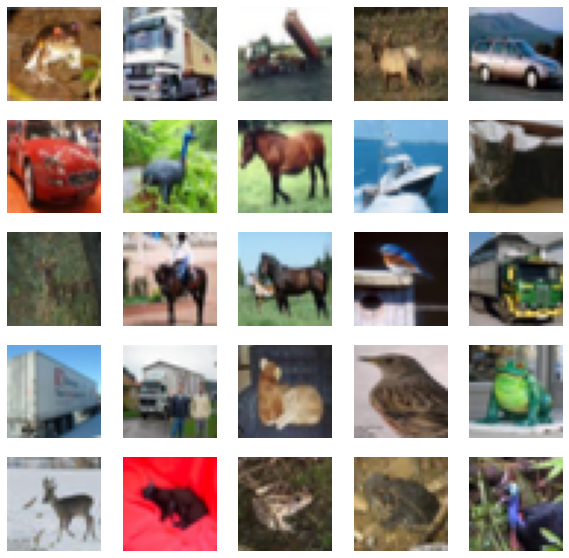

In [4]:
plt.figure(figsize=(10, 10))

for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow((train_x[i] + 1) / 2.0)  # 정규화 해제하여 이미지 표시
    plt.axis('off')

plt.show()

In [5]:
# tf.data.Dataset 모듈의 from_tensor_slices() 함수를 사용하여 미니배치 데이터셋 구성
batch_size = 64
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(train_x.shape[0]).batch(batch_size)

(32, 32, 3)의 shape를 가진 이미지를 생성하는 생성자 모델 구현 함수를 작성해 봅시다.\
noise = tf.random.normal([1, 100])로 생성된 랜덤 노이즈를 입력으로 하여 방금 구현한 생성자로 랜덤 이미지를 생성해 봅시다.\
생성된 랜덤 이미지가 생성자 출력 규격에 잘 맞는지 확인해 봅시다.

In [6]:
def make_generator_model():
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    # 위에서 마지막 Conv2DTranspose 층의 출력 채널을 3으로 변경하여 컬러 이미지를 생성하도록 함

    return model

# 생성자 모델을 만들기
generator = make_generator_model()

# 랜덤 노이즈 생성
noise = tf.random.normal([1, 100])

# 생성자 모델을 사용하여 랜덤 이미지 생성
generated_image = generator(noise, training=False)

# 생성된 이미지의 shape 출력
print("생성된 이미지의 shape:", generated_image.shape)


생성된 이미지의 shape: (1, 32, 32, 3)


In [7]:
def make_discriminator_model():
    model = tf.keras.Sequential()

    # Conv2D layer 1
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Conv2D layer 2
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Flatten layer
    model.add(layers.Flatten())

    # Dense layer (output 1 dimension)
    model.add(layers.Dense(1))

    return model


In [8]:
# 판별자 모델 생성
discriminator = make_discriminator_model()

# 생성된 이미지를 판별자 모델이 판별한 결과값 확인
decision = discriminator(generated_image)
print("판별 결과값:", decision.numpy())

판별 결과값: [[-0.0020607]]


In [9]:
# 생성자와 판별자의 손실 함수 및 정확도를 계산하는 함수
def discriminator_loss(real_output, fake_output):
    # 손실함수는 cross entropy를 사용, ones_like를 활용
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    # 손실함수는 cross entropy를 사용, zeros_like를 활용
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    # real_loss와 fake_loss를 더한 값
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return tf.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output, from_logits=True)

def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, 0.5), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, 0.5), tf.float32))
    return real_accuracy, fake_accuracy

# 생성자와 판별자를 최적화하는 optimizer 정의
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [10]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4) # 1e-4: 10의 -4승 = 0.0001
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [11]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

In [12]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [13]:
@tf.function # TensorFlow의 tf.function 데코레이터를 사용하여 이 함수를 TensorFlow 그래프로 컴파일한다. 이렇게 하면 성능 향상이 기대된다.
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([batch_size, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
                                                                         # 두 개의 tf.GradientTape 컨텍스트를 연다. 
                                                                         # 이는 생성자와 판별자의 각각의 파라미터에 대한 그래디언트를 계산하기 위함
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산 - 판별자의 실제 이미지와 가짜 이미지에 대한 정확도를 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables) # generator.trainable_variables는 생성자 모델의 학습 가능한 변수(가중치 및 편향)들을 나타내는 TensorFlow 변수들의 리스트 
                                                                                        # 학습 가능한 변수들은 모델이 학습 중에 업데이트되는 매개변수들을 의미
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습 - 계산된 그래디언트를 사용하여 생성자와 판별자를 업데이트
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

In [14]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        generated_image = (predictions[i, :, :, :] + 1) / 2.0  # 픽셀 값 범위를 [0, 1]로 조정
        plt.imshow(generated_image)
        plt.axis('off')
   
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()


In [15]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

In [16]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [17]:
def train(dataset, epochs, save_every): # save_every - 일정 주기로 체크포인트롤 저장할 인자
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]} # history 딕셔너리는 학습 중에 발생한 생성자 손실, 판별자 손실, 
                                                                                      # 그리고 실제와 가짜 이미지에 대한 정확도를 기록하는 용도로 사용

    for epoch in range(epochs): # for 루프를 사용하여 에폭과 이터레이션을 순회하면서 모델을 학습
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch) 
            history['gen_loss'].append(gen_loss) # train_step 함수를 호출하여 각 배치에 대한 학습을 진행하고, 손실 및 정확도를 history에 기록
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0: # 매 50번째 이터레이션마다 생성된 이미지를 시각화하고 현재 학습 진행 상황을 출력
                display.clear_output(wait=True) # 출력된 이미지 등을 화면에서 지우고 새로운 이미지를 표시하기 위해 화면을 깨끗하게 지움
                generate_and_save_images(generator, epoch+1, it+1, seed) # 현재 에폭(epoch+1), 현재 이터레이션(it+1), 그리고 랜덤 시드(seed)를 전달
                print('Epoch {} | iter {}'.format(epoch+1, it+1)) # 현재 에폭과 이터레이션 정보를 출력
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start))) # 현재 에폭이 진행된 시간(경과 시간)을 계산하고 출력

        if (epoch + 1) % save_every == 0: # 일정 주기(save_every)마다 체크포인트를 저장, - 현재 에폭이 일정 주기(save_every)의 배수일 때마다 아래의 블록을 실행
                                          # 이는 학습 중에 중단되더라도 마지막 체크포인트부터 다시 학습을 시작할 수 있게 해줌
            checkpoint.save(file_prefix=checkpoint_prefix) # file_prefix 매개변수는 체크포인트 파일의 접두어를 지정합니다. 
                                                           # 이를 통해 나중에 해당 체크포인트를 불러올 때 사용

        display.clear_output(wait=True) # 각 에폭이 끝날 때마다 현재까지의 학습 결과를 시각화하고, 학습에 소요된 전체 시간을 출력
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch) # draw_train_history 함수를 호출하여 학습 중에 기록된 손실 및 정확도의 변화를 그래프로 그린다. 
                                           # 이는 학습이 어떻게 진행되었는지를 시각적으로 확인하는 데 도움이 된다.

In [18]:
save_every = 5
EPOCHS = 200

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

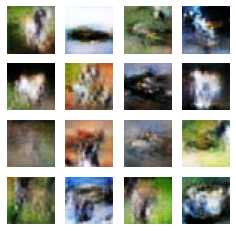

Time for training : 2069 sec


In [ ]:
%%time
train(train_dataset, EPOCHS, save_every)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/fashion/training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인해 보시길 권합니다.